### prepare the enviornment
there are some useful packages you need to install first including:
    #scipy
    #sklearn
    #pytorch
    #torch_geometric
 
### Download the dataset from google drive
#link:
https://drive.google.com/drive/folders/1BvCqOozyt5v4zrNPkyFq_rpFdxddsVCm?usp=sharing

In [1]:
import os
import sys
import math
import time
import datetime

import numpy as np
import pandas as pd
import scipy.io

import nibabel as nib
from scipy import sparse
from scipy.stats import spearmanr
from sklearn import preprocessing, metrics,manifold
from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
import itertools


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torch_sparse import spmm
from torch_scatter import scatter_add
from torch_geometric.utils import add_self_loops

from utils import *

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='once')

### step1: building brain graphs
we need to load brain connectome. Here, I have prepared a group-averaged diffusion tractography matrix, 
#which includes the percentage of fiber connections between each pair of brain regions

(array([123924.,   1848.,    856.,    444.,    316.,    268.,    200.,
           224.,    158.,    168.]),
 array([0.        , 0.09998608, 0.19997216, 0.29995824, 0.39994433,
        0.49993041, 0.59991649, 0.69990257, 0.79988865, 0.89987473,
        0.99986081]),
 <a list of 10 Patch objects>)

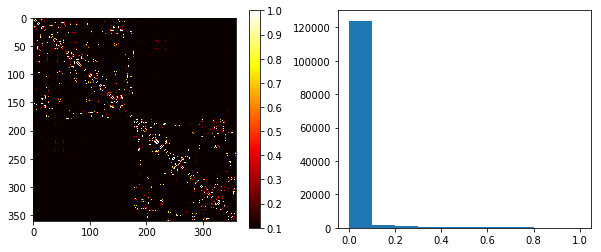

In [2]:
##step1: load brain connectome

adjacent_mat_file = "../data/brain_graph/MMP_DiffusionConnectivity_HCP_avg56.mat"
mat = scipy.io.loadmat(adjacent_mat_file)
corr_matrix_z = mat['SC_avg56']
num_nodes = corr_matrix_z.shape[0]

fig=plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.imshow(corr_matrix_z, cmap="hot",vmin=0.1, vmax=1)
plt.colorbar()

fig.add_subplot(122)
plt.hist(corr_matrix_z[corr_matrix_z<1])

### Step2: build a k-NN graph.
Based on the connectivity-matrix shown above, we need to next build a KNN graph, with each node only connecting to #k other neighbours, selected based on connectivity strengths

/home/yzhang/miniconda3/envs/tensorflow-py3.6/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(array([2118.,  234.,  172.,  166.,  170.,  148.,  156.,  122.,  156.,
          92.]),
 array([6.14701167e-270, 1.00000000e-001, 2.00000000e-001, 3.00000000e-001,
        4.00000000e-001, 5.00000000e-001, 6.00000000e-001, 7.00000000e-001,
        8.00000000e-001, 9.00000000e-001, 1.00000000e+000]),
 <a list of 10 Patch objects>)

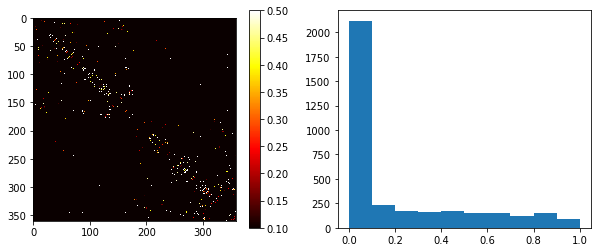

In [3]:
## Step2: build a k-NN graph.

def build_adjacency(dist, idx):
    """Return the adjacency matrix of a kNN graph."""
    M, k = dist.shape
    assert M, k == idx.shape
    assert dist.min() >= 0

    # Weights.
    sigma2 = np.mean(dist[:, -1])**2
    dist = np.exp(- dist**2 / sigma2)

    # Weight matrix.
    I = np.arange(0, M).repeat(k)
    J = idx.reshape(M*k)
    V = dist.reshape(M*k)
    W = sparse.coo_matrix((V, (I, J)), shape=(M, M))

    # No self-connections.
    W.setdiag(0)

    # Non-directed graph.
    bigger = W.T > W
    W = W - W.multiply(bigger) + W.T.multiply(bigger)
    return W

Nneighbours=8
idx = np.argsort(-corr_matrix_z)[:, 1:Nneighbours + 1]
dist = np.array([corr_matrix_z[i, idx[i]] for i in range(corr_matrix_z.shape[0])])
dist[dist < 0.1] = 0
adj_mat_sp = build_adjacency(dist, idx)

fig=plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.imshow(adj_mat_sp.todense(), cmap="hot",vmin=0.1, vmax=0.5);
plt.colorbar()

fig.add_subplot(122)
plt.hist(adj_mat_sp.data)


### Step 3: Laplacian Matrix:
\begin{equation*}
\label{eq_laplacian}
L=I-D^{-1/2}WD^{-1/2}
\end{equation*}

In order to leavage the computing power from sparse tensor of pytorch, we convert the KNN graph to a sparse tensor
#then the Laplacian Matrix is calculated


Converting from scipy sparse matrix:
[  2   4   5 ... 248 343 358]
[1.20991668e-02 2.25504229e-74 2.70600250e-04 ... 4.19549925e-02
 5.11535778e-01 7.31470842e-12]
Converting to torch sparse tensor:
tensor([[  2,   4,   5,  ..., 248, 343, 358],
        [  0,   0,   0,  ..., 359, 359, 359]])
tensor([1.2099e-02, 0.0000e+00, 2.7060e-04,  ..., 4.1955e-02, 5.1154e-01,
        7.3147e-12])

Calculation time for Laplacian matrix:0.03477621078491211s


(array([ 360.,    0.,    0.,    0.,    0., 2186.,  932.,  338.,   68.,
          10.]),
 array([-1.        , -0.81988215, -0.63976437, -0.45964652, -0.27952868,
        -0.09941086,  0.08070697,  0.2608248 ,  0.44094262,  0.62106043,
         0.8011783 ], dtype=float32),
 <a list of 10 Patch objects>)

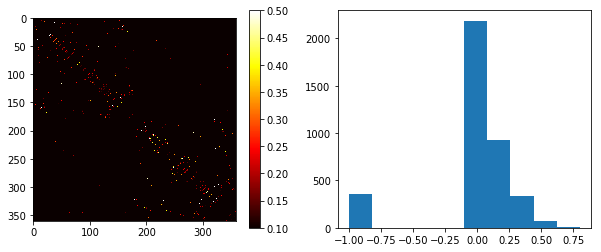

In [4]:
###Step 3: Laplacian Matrix: L=I-D(-1/2)AD(-1/2)
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

t0 = time.time()
adj_mat = sparse_mx_to_torch_sparse_tensor(adj_mat_sp)
print("Converting from scipy sparse matrix:")
print(adj_mat_sp.indices)
print(adj_mat_sp.data)
print("Converting to torch sparse tensor:")
print(adj_mat._indices())
print(adj_mat._values())

edge_index = adj_mat._indices()
edge_weight = adj_mat._values()
row, col = edge_index
        
#degree-matrix
deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)

# Compute normalized and rescaled Laplacian.
deg = deg.pow(-0.5)
deg[torch.isinf(deg)] = 0
lap = deg[row] * edge_weight * deg[col]

###Rescale the Laplacian eigenvalues in [-1, 1]
##rescale: 2L/lmax-I; lmax=1.0
fill_value = 1  ##-0.5
edge_index, lap = add_self_loops(edge_index, -lap, fill_value, num_nodes)

laplacian_matrix = sparse.coo_matrix((lap.numpy(),edge_index),shape=(num_nodes,num_nodes))
print("\nCalculation time for Laplacian matrix:{}s".format(time.time()-t0))
fig=plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.imshow(-laplacian_matrix.todense(), cmap="hot",vmin=0.1, vmax=0.5);
plt.colorbar()

fig.add_subplot(122)
plt.hist(-laplacian_matrix.data)

### Step 4: Spectral decomposition
Next, we apply eigen-decomposition to the Laplacian matrix
\begin{equation*}
Lx = \lambda x
\end{equation*}

which give us
eigenvalues: 
\begin{equation*}
{\{\lambda_i,i=0..n\}}
\end{equation*}
and
eigenvectors:
\begin{equation*}
{\{v_i,i=0..n\}}
\end{equation*}

Text(0.5, 1.0, '2nd EigenVectors')

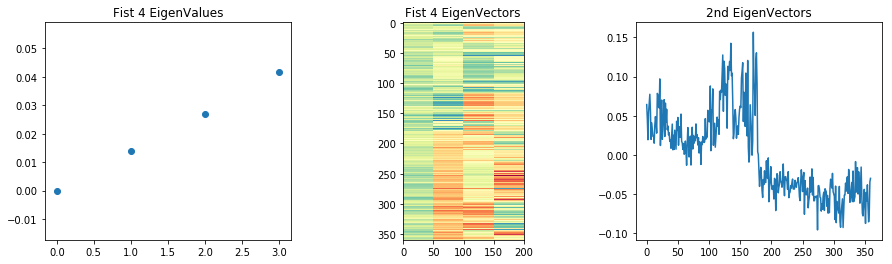

In [5]:
###Step 4: Spectral decomposition
from scipy.linalg import eigh
w, v = eigh(laplacian_matrix.todense()) # w = eigenvalues, v = eigenvectors

K_eigbasis = min(4,num_nodes)
fig=plt.figure(figsize=(15,4))
fig.add_subplot(131)
plt.scatter(range(K_eigbasis),w[:K_eigbasis])
plt.title("Fist {} EigenValues".format(K_eigbasis))

fig.add_subplot(132)
plt.imshow(np.repeat(v[:,:K_eigbasis],50,axis=1), cmap="Spectral")
plt.title("Fist {} EigenVectors".format(K_eigbasis))

fig.add_subplot(133)
plt.plot(v[:,1])
plt.title("2nd EigenVectors")

### Example #1: Using eigvectors for clustering
mapping 2nd and 3rd eigvectors and spectral clustering
spectral clustering: 
#First, decomposing the Laplacian matrix; 
#second, collect the first $k eigenvectors 
#third, performing k-means clustering on the projected new features (low dim)

#fourth, we compare the clustering results with the cluster module from sklearn

/home/yzhang/miniconda3/envs/tensorflow-py3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


[[1.         0.97801929]
 [0.97801929 1.        ]]


/home/yzhang/miniconda3/envs/tensorflow-py3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


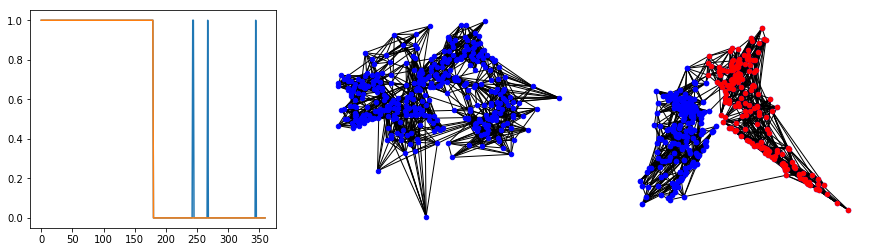

In [6]:
##Example #1: mapping 2nd and 3rd eigvectors and spectral clustering

##spectral clustering from sklearn
from sklearn import cluster
sp_clustering = cluster.SpectralClustering(n_clusters=2,eigen_solver='arpack',affinity='precomputed',
                                   assign_labels="discretize",random_state=1234).fit(corr_matrix_z)
sp_clustering.labels_

##spectral clustering: applying k-means to first k eigenvectors
sk_clustering = cluster.KMeans(n_clusters=2, random_state=1234).fit(v[:,:K_eigbasis])
sk_clustering.labels_
clusters = np.array([sp_clustering.labels_,sk_clustering.labels_]).transpose()
print(np.corrcoef(sp_clustering.labels_,sk_clustering.labels_))

fig=plt.figure(figsize=(15,4))
fig.add_subplot(131)
plt.plot(clusters)

##visualize the graph architecture
import networkx as nx
graph = nx.from_scipy_sparse_matrix(adj_mat_sp, parallel_edges=False, create_using=None, edge_attribute='weight')
pos = nx.spring_layout(graph) 
fig.add_subplot(132)
nx.draw(graph, pos, node_size=20, node_color='b')

pos = {i : (v[i,1], v[i,2]) for i in range(num_nodes)}
fig.add_subplot(133)
# set of nodes
nx.draw(graph, pos, node_size=20, node_color='b')
nx.draw_networkx_nodes(graph, pos, 
                       nodelist=list(np.where(sk_clustering.labels_==1)[0]),
                       node_color='r',node_size=20)
nx.draw_networkx_nodes(graph, pos, 
                       nodelist=list(np.where(sk_clustering.labels_==0)[0]),
                       node_color='b',node_size=20,)
plt.show()

### Example #2: Transfer fmri data to spectral domain using Graph Fourier Transform
Graph Fourier Transform:
\begin{equation*}
\hat{x} = \mathcal{L}\{x\} = U^T x
\end{equation*}
and its inverse transform:
\begin{equation*}
x = U \hat{x}
\end{equation*}

### step1: loading fmri data and event design
we have stored the fmri time-series for each brain region in a lmdb file
#the event labels are stored in a h5 file

/home/yzhang/miniconda3/envs/tensorflow-py3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/yzhang/miniconda3/envs/tensorflow-py3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/yzhang/miniconda3/envs/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:5201: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/yzhang/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/home/yzhang/miniconda3/envs/tensorflow-py3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


loading data from file: ../data/MOTOR_MMP_ROI_act_test_sub100.lmdb
Search each key for every fmri file...
(100, 284, 360) (100, 284)


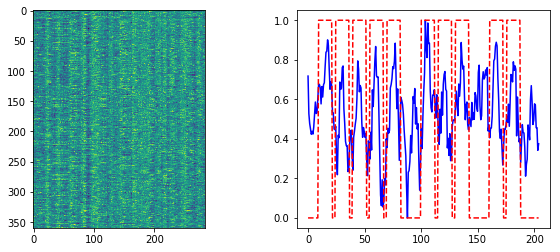

In [7]:

#step1: load fmri data and event labels

fmri_file = "../data/MOTOR_MMP_ROI_act_test_sub100.lmdb"
event_file = "../data/MOTOR_event_labels_test_sub100_newLR.h5"

sub100_tc_matrix, subname100 = load_fmri_data_from_lmdb(fmri_file)
sub100_trial_labels, sub100_trialID, sub100_sub_name, sub100_coding_direct = extract_event_data(event_file)
print(np.array(sub100_tc_matrix).shape,np.array(sub100_trial_labels).shape)

Subject_Num = np.array(sub100_tc_matrix).shape[0]
Trial_Num = np.array(sub100_tc_matrix).shape[1]
TR = 0.72

tc_roi_matrix = sub100_tc_matrix[0].transpose()
event_design = sub100_trial_labels.iloc[0]
event_select = np.zeros((Trial_Num,1))
for ei in np.where(event_design!='rest'):
    event_select[ei]=1

##plot regional tc aligned with event design
region_index = np.argsort(tc_roi_matrix.var(axis=-1))
tc_roi_matrix_sort = [tc_roi_matrix[ii,:] for ii in region_index]
event_time = np.arange(Trial_Num)*TR

fig=plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.imshow(tc_roi_matrix_sort)

fig.add_subplot(122)
fmri_tc = preprocessing.MinMaxScaler().fit_transform(tc_roi_matrix[region_index[350],:].reshape(-1,1))
plt.plot(event_time,fmri_tc,'b')
plt.plot(event_time, event_select,'r--')

### step2: Matching fmri data with event design according to time
#extract 10 task trials from one fmri scan
#get the corresponding task label for each trial

In [ ]:
####build the label and data matrix
#print(task_contrasts)
task_contrasts = ['footL_mot','footR_mot','handL_mot','handR_mot','tongue_mot']
le = preprocessing.LabelEncoder()
le.fit(task_contrasts)
label_trial_task = np.array(le.transform(event_design[event_design!='rest']))
label_trial_task = np.array(np.split(label_trial_task, np.where(np.diff(label_trial_task))[0] + 1))[:,0]
task_idx = np.argsort(label_trial_task)
task_names = [le.inverse_transform(label_trial_task)[idx] for idx in task_idx]

###extract BOLD signals according to trial info
event_trial_block = np.split(event_select.astype(int), np.where(np.diff(event_select.astype(int),axis=0))[0] + 1)
fmri_trial_block = np.split(tc_roi_matrix, np.where(np.diff(event_select.astype(int),axis=0))[0] + 1,axis=-1)


fmri_trial_task = []
for ii in range(len(event_trial_block)):
    if np.unique(event_trial_block[ii]) !=0 :
        ##print(fmri_trial_block[ii].shape)
        fmri_trial_task.append(fmri_trial_block[ii].mean(axis=-1))
fmri_trial_task = np.array(fmri_trial_task)
print(fmri_trial_task.shape)
fig=plt.figure(figsize=(10,4))
fig.add_subplot(121)

correlation = np.corrcoef([fmri_trial_task[idx,:] for idx in task_idx])
plt.imshow(correlation, cmap="jet",vmin=0.2, vmax=1.0)
plt.yticks(np.arange(10), task_names)
plt.colorbar()
            
###map BOLD signals to 2d space  
tsne = manifold.TSNE(n_components=2, init='pca', random_state=1234, n_iter=10000)
output_2d = tsne.fit_transform(fmri_trial_task)
fig.add_subplot(122)
plt.scatter(output_2d[:, 0], output_2d[:, 1], c=label_trial_task)
plt.tight_layout()
plt.show()


### Step3: performing graph fourier transform to all fmri trials
\begin{equation*}
\hat{x} = \mathcal{L}\{x\} = U^T x
\end{equation*}

Text(0.5, 1.0, 'High frequency graph mode of fmri tc')

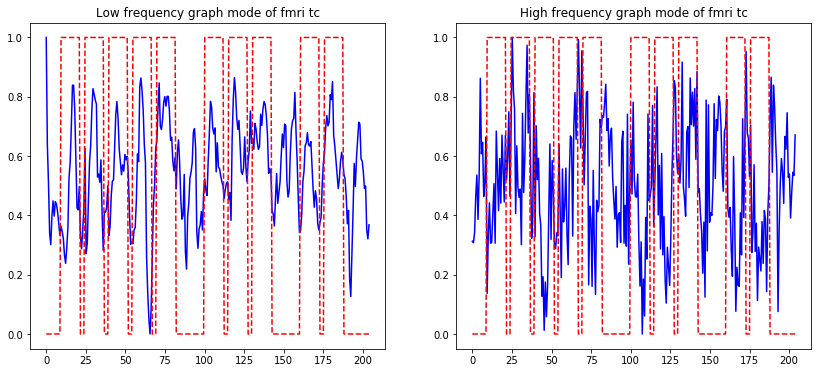

In [9]:
##graph fourier transform:  L(x)=U'x
low_mode = v[:,0]
low_mode = np.matmul(tc_roi_matrix.T,low_mode)
high_mode = v[:,-1]
high_mode = np.matmul(tc_roi_matrix.T,high_mode)

fig=plt.figure(figsize=(14,6))
fig.add_subplot(121)
fmri_tc = preprocessing.MinMaxScaler().fit_transform(low_mode.reshape(-1,1))
plt.plot(event_time,fmri_tc,'b')
plt.plot(event_time, event_select,'r--')
plt.title('Low frequency graph mode of fmri tc')

fig.add_subplot(122)
fmri_tc = preprocessing.MinMaxScaler().fit_transform(high_mode.reshape(-1,1))
plt.plot(event_time,fmri_tc,'b')
plt.plot(event_time, event_select,'r--')
plt.title('High frequency graph mode of fmri tc')


### Step4: Transform fmri data to different graph modes across different frequency bands 
#low-freq: 1..20
#mid-freq: 100..120
#and high-freq: 340:end


(20, 284)
(10, 340)


Text(0.5, 1.0, 'High freq graph mode')

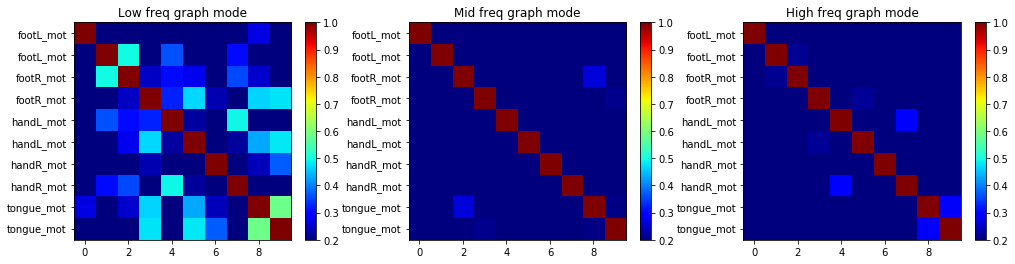

In [10]:
###nonlinear mapping
kmodes=20
laplacian_mode1 = np.matmul(tc_roi_matrix.T,v[:,1:kmodes+1]).transpose()
laplacian_mode2 = np.matmul(tc_roi_matrix.T,v[:,100:100+kmodes]).transpose()
laplacian_mode3 = np.matmul(tc_roi_matrix.T,v[:,kmodes:]).transpose()

print(laplacian_mode1.shape)
###extract BOLD signals according to trial info
event_trial_block = np.split(event_select.astype(int), np.where(np.diff(event_select.astype(int),axis=0))[0] + 1)
fmri_trial_block = np.split(laplacian_mode1, np.where(np.diff(event_select.astype(int),axis=0))[0] + 1,axis=-1)
fmri_trial_task = []
for ii in range(len(event_trial_block)):
    if np.unique(event_trial_block[ii]) !=0 :
        fmri_trial_task.append(fmri_trial_block[ii].flatten())
fmri_trial_task = np.array(fmri_trial_task)
print(fmri_trial_task.shape)

fig=plt.figure(figsize=(17,4))
fig.add_subplot(131)
correlation = np.corrcoef([fmri_trial_task[idx,:] for idx in task_idx])
plt.imshow(correlation, cmap="jet",vmin=0.2, vmax=1.0)
plt.yticks(np.arange(10), task_names)
plt.colorbar()
plt.title("Low freq graph mode")

fmri_trial_block = np.split(laplacian_mode2, np.where(np.diff(event_select.astype(int),axis=0))[0] + 1,axis=-1)
fmri_trial_task = []
for ii in range(len(event_trial_block)):
    if np.unique(event_trial_block[ii]) !=0 :
        fmri_trial_task.append(fmri_trial_block[ii].flatten())
fmri_trial_task = np.array(fmri_trial_task)
fig.add_subplot(132)
correlation = np.corrcoef([fmri_trial_task[idx,:] for idx in task_idx])
plt.imshow(correlation, cmap="jet",vmin=0.2, vmax=1.0)
plt.yticks(np.arange(10), task_names)
plt.colorbar()
plt.title("Mid freq graph mode")

fmri_trial_block = np.split(laplacian_mode3, np.where(np.diff(event_select.astype(int),axis=0))[0] + 1,axis=-1)
fmri_trial_task = []
for ii in range(len(event_trial_block)):
    if np.unique(event_trial_block[ii]) !=0 :
        fmri_trial_task.append(fmri_trial_block[ii].flatten())
fmri_trial_task = np.array(fmri_trial_task)
fig.add_subplot(133)
correlation = np.corrcoef([fmri_trial_task[idx,:] for idx in task_idx])
plt.imshow(correlation, cmap="jet",vmin=0.2, vmax=1.0)
plt.yticks(np.arange(10), task_names)
plt.colorbar()
plt.title("High freq graph mode")

### Next we going to explore GCN, which automatically learns a combination of graph modes
First, we need to build a dataset and dataloader to load fmri data
#Here, for simplicity, we move the dataset function to utils.py, check the python script if you are interested
### dataset in pytorch includes three parts: _init_(); _len_(); _get_item()
second, we need our own version of collect-smaples function
#Check the function in utils.py script
### fmri_samples_collate_fn: input: data, output: fmri-data and event-labels
#
#
### Now, the first step is to define our dataset and dataloader, which give a fmri trial and corresponding task label each time

In [11]:
modality='MOTOR'
task_contrasts = {"rf": "footR_mot",
                  "lf": "footL_mot",
                  "rh": "handR_mot",
                  "lh": "handL_mot",
                  "t": "tongue_mot"}
params = {'batch_size': 2,
          'shuffle': True,
          'num_workers': 1}

target_name = (list(task_contrasts.values()))
print(target_name)
Nlabels = len(target_name) + 1
fmri_train_dataset = HCP_taskfmri_matrix_datasets(sub100_tc_matrix, sub100_trial_labels, target_name, block_dura=17, isTrain='train')
                
train_loader = DataLoader(fmri_train_dataset, collate_fn=fmri_samples_collate_fn, **params)
data,label = next(iter(train_loader))
print(data.shape,label.shape)

['footR_mot', 'footL_mot', 'handR_mot', 'handL_mot', 'tongue_mot']
torch.Size([20, 360, 17]) torch.Size([20])


### Second step is to split the entire dataset into train and test tests
training on 80% of subjects and test on the rest 20% subjects

In [12]:
###split the entire dataset into train and test tests
###############################
params = {'batch_size': 2,
          'shuffle': True,
          'num_workers': 2}

Region_Num = sub100_tc_matrix[0].shape[-1]
block_dura = 17    
test_size = 0.2
randomseed=1234

test_sub_num = len(sub100_tc_matrix)
rs = np.random.RandomState(randomseed)
train_sid, test_sid = train_test_split(range(test_sub_num), test_size=test_size, random_state=rs, shuffle=True)
print('training on %d subjects, validating on %d subjects' % (len(train_sid), len(test_sid)))

####train set
fmri_data_train = [sub100_tc_matrix[i] for i in train_sid]
label_data_train = pd.DataFrame(np.array([sub100_trial_labels.iloc[i] for i in train_sid]))
fmri_train_dataset = HCP_taskfmri_matrix_datasets(fmri_data_train, label_data_train, target_name, block_dura=17, isTrain='train')
train_loader = DataLoader(fmri_train_dataset, collate_fn=fmri_samples_collate_fn, **params)

####test set
fmri_data_test = [sub100_tc_matrix[i] for i in test_sid]
label_data_test = pd.DataFrame(np.array([sub100_trial_labels.iloc[i] for i in test_sid]))
fmri_test_dataset = HCP_taskfmri_matrix_datasets(fmri_data_test, label_data_test, target_name, block_dura=17, isTrain='test')
test_loader = DataLoader(fmri_test_dataset, collate_fn=fmri_samples_collate_fn, **params)

training on 80 subjects, validating on 20 subjects


### Third step is to build our DNN model and start training
first we test on a simple 2-layer MLP
#Here we used a function called "model_fit_evaluate", which includes training the provided model for 20 epochs, and returning the history of training as a plot

cpu
FCN(
  (linear): Linear(in_features=360, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=32, out_features=6, bias=True)
  )
)
50534 paramters to be trained in the model



/data/cisl/yuzhang/projects/HCP/main_tutorial_gcn/gitclone/gcn_tutorial_test/notebooks/model.py:129: DeprecationWarning: invalid escape sequence \m
  """



Epoch 0: 
Time Usage:0.528304 | Training Loss 0.082116 | Acc 0.320000
Test Loss 0.074777 | Acc 0.420000
Model updated: Best-Acc = 0.420000

Epoch 1: 
Time Usage:0.510266 | Training Loss 0.067386 | Acc 0.485000
Test Loss 0.058332 | Acc 0.625000
Model updated: Best-Acc = 0.625000

Epoch 2: 
Time Usage:0.573087 | Training Loss 0.054276 | Acc 0.603750
Test Loss 0.047029 | Acc 0.685000
Model updated: Best-Acc = 0.685000

Epoch 3: 
Time Usage:0.493396 | Training Loss 0.042242 | Acc 0.713750
Test Loss 0.037317 | Acc 0.790000
Model updated: Best-Acc = 0.790000

Epoch 4: 
Time Usage:0.560453 | Training Loss 0.030811 | Acc 0.803750
Test Loss 0.029130 | Acc 0.820000
Model updated: Best-Acc = 0.820000

Epoch 5: 
Time Usage:0.651833 | Training Loss 0.023842 | Acc 0.853750
Test Loss 0.024157 | Acc 0.840000
Model updated: Best-Acc = 0.840000

Epoch 6: 
Time Usage:0.539817 | Training Loss 0.019428 | Acc 0.888750
Test Loss 0.021307 | Acc 0.870000
Model updated: Best-Acc = 0.870000

Epoch 7: 
Time Usag

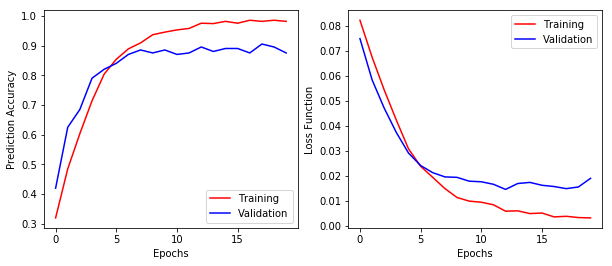

In [14]:
from model import FCN
from model import count_parameters, train, test, plot_history

###fully-connected
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

model = FCN(Region_Num, Nlabels)
model = model.to(device)
print(model)
print("{} paramters to be trained in the model\n".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss()
num_epochs=20

model_fit_evaluate(model,adj_mat,device,train_loader,test_loader,optimizer,loss_func,num_epochs)

### Next, we tried with graph convolutional networks
there are two versions we test here: 1stGCN and ChebyNet;
#We will see the power of including higher k-orders

Using GCN Layers instead
ChebNet(
  (graph_features): ModuleList(
    (0): GraphConv (17 -> 32)
    (1): GraphConv (32 -> 32)
    (2): GraphConv (32 -> 32)
  )
  (dropout): Dropout(p=0.25)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=6, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.25)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=32, out_features=6, bias=True)
  )
)
55388 paramters to be trained in the model


Epoch 0: 
Time Usage:19.069239 | Training Loss 0.087076 | Acc 0.188750
Test Loss 0.085536 | Acc 0.205000
Model updated: Best-Acc = 0.205000

Epoch 1: 
Time Usage:18.288010 | Training Loss 0.085001 | Acc 0.200000
Test Loss 0.083854 | Acc 0.205000

Epoch 2: 
Time Usage:18.261657 | Training Loss 0.084036 | Acc 0.198750
Test Loss 0.082232 | A

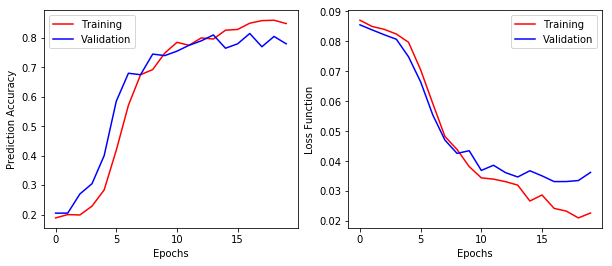

In [16]:
from model import ChebNet

filters=32
num_layers=2
model_test = ChebNet(block_dura, filters, Nlabels, gcn_layer=num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer,loss_func,num_epochs)

In [ ]:
model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer,loss_func,num_epochs)

ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(17, 32, K=5)
    (1): ChebConv(32, 32, K=5)
    (2): ChebConv(32, 32, K=5)
  )
  (dropout): Dropout(p=0.25)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=6, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.25)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=32, out_features=6, bias=True)
  )
)
68348 paramters to be trained in the model


Epoch 0: 
Time Usage:52.398875 | Training Loss 0.087336 | Acc 0.190000
Test Loss 0.085297 | Acc 0.200000
Model updated: Best-Acc = 0.200000

Epoch 1: 
Time Usage:50.795203 | Training Loss 0.084223 | Acc 0.230000
Test Loss 0.082876 | Acc 0.210000
Model updated: Best-Acc = 0.210000

Epoch 2: 
Time Usage:47.677867 | Training Loss 0.084204 | Acc 0.198750
Test Loss